In [1]:
import cv2
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import itertools
import pickle

In [2]:
root_path = pathlib.Path(r'D:\Datasets\Golf\IdeasLab\validation')
folders = list(root_path.iterdir())

In [3]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	if len(boxes) == 0:
		return []
	pick = []
 
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2] + boxes[:, 0]
	y2 = boxes[:, 3] + boxes[:, 1]

	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	if probs is not None:
		idxs = probs
	idxs = np.argsort(idxs)

	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		overlap = (w * h) / area[idxs[:last]]

		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
  
	return boxes[pick].astype("int")

def pick_the_center_one(img,picks):
    img_center_coor = np.array(img.shape[:2])[::-1]/2
    picks_center_coor = picks[:,:2]+picks[:,2:]/2
    pos = np.argmin(np.sqrt(((picks_center_coor - img_center_coor)**2).sum(axis=1)))
    return picks[pos]

def transition_to_original_coor(target_image,source_image,xywh):
    target_shape = np.array(target_image.shape[:2])
    source_shape = np.array(source_image.shape[:2])
    t_xywh = np.empty_like(xywh)
    if len(xywh.shape) == 2:
        t_xywh[:,[0,2]] = np.round(xywh[:,[0,2]]/source_shape[1]*target_shape[1])
        t_xywh[:,[1,3]] = np.round(xywh[:,[1,3]]/source_shape[0]*target_shape[0])
    else:
        assert len(xywh.shape) == 1
        t_xywh[[0,2]] = np.round(xywh[[0,2]]/source_shape[1]*target_shape[1])
        t_xywh[[1,3]] = np.round(xywh[[1,3]]/source_shape[0]*target_shape[0])
    return t_xywh

In [4]:
class HumanDetectModel:
    def __init__(self,
                 use_default_detector:bool=False,
                 res_reduce:int=5,
                 winStride:tuple=(8,8),
                 winPadding:tuple=(0,0),
                 useMeanshiftGrouping:bool=False,
                 scale:float=1.05,
                 ):
        if use_default_detector:
            hog  = cv2.HOGDescriptor(_winSize=(64,128),_blockSize=(16,16),_blockStride=(8,8),_cellSize=(8,8),_nbins=9)
            hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
        else:
            hog = cv2.HOGDescriptor(_winSize=(48,96),_blockSize=(16,16),_blockStride=(8,8),_cellSize=(8,8),_nbins=9)
            hog.setSVMDetector(cv2.HOGDescriptor_getDaimlerPeopleDetector())
            
        self.hog = hog
        self.res_reduce = res_reduce
        self.winStride = winStride
        self.winPadding = winPadding
        self.useMeanshiftGrouping = useMeanshiftGrouping
        self.scale = scale
        
    def detect(self,image,nms_threshold=0.05):
        h,w = image.shape[:2]
        detect_image = cv2.resize(image,(w//self.res_reduce,h//self.res_reduce))
        rects, weights = self.hog.detectMultiScale(
            detect_image,
            winStride=self.winStride,
            padding=self.winPadding,
            useMeanshiftGrouping=self.useMeanshiftGrouping,
            scale=self.scale)
        
        if len(rects) != 0:
            picks = non_max_suppression(rects,weights.squeeze(),nms_threshold)
            picks = transition_to_original_coor(image,detect_image,picks)
            pick = pick_the_center_one(image,picks)
        return picks,pick
    
class ClubDetectModel:
    def __init__(self,
                 load_model_path,
                 winStride:tuple=(8,8)):
        with pathlib.Path(load_model_path).open('rb') as f:
            model = pickle.load(f)
        self.detector = model['detector']
        self.hog = cv2.HOGDescriptor(**model['hog_setting'])
        self.winSize = model['hog_setting']['_winSize']
        self.winStride = winStride
        
        steps = (((model['hog_setting']['_winSize'][0]-model['hog_setting']['_blockSize'][0])//model['hog_setting']['_blockStride'][0]+1) * 
                 ((model['hog_setting']['_winSize'][1]-model['hog_setting']['_blockSize'][1])//model['hog_setting']['_blockStride'][1]+1))
        grids = ((model['hog_setting']['_blockSize'][0]//model['hog_setting']['_cellSize'][0]) * 
                 (model['hog_setting']['_blockSize'][1]//model['hog_setting']['_cellSize'][1]))
        self.feature_dim =  steps * grids * model['hog_setting']['_nbins']
        
    def detect(self,image,nms_threshold=0.05):
        hog_feature = self.hog.compute(image, winStride=self.winStride, padding=(0,0))
        preds = self.detector.predict(hog_feature.reshape(-1,self.feature_dim))
        h,w = image.shape[:2]
        W = list(range(0,w-self.winSize[0],self.winStride[0])) + [w-self.winSize[0]]
        H = list(range(0,h-self.winSize[1],self.winStride[1])) + [h-self.winSize[1]]
        rects = np.array(list(itertools.product(H,W)))[np.where(preds==1)[0]][:,::-1]
        rects = np.concatenate([rects,np.broadcast_to(np.array(self.winSize),rects.shape)],axis=1)
        picks = non_max_suppression(rects,overlapThresh=nms_threshold)
        return picks
        

In [5]:
human_detector = HumanDetectModel()
club_detector = ClubDetectModel('saved_models/svm_rbf_model_4.ml')

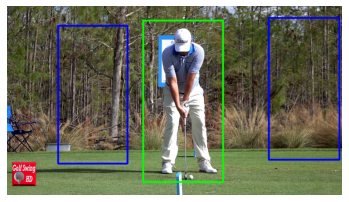

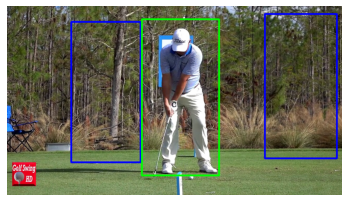

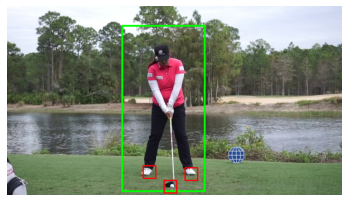

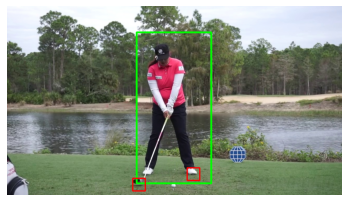

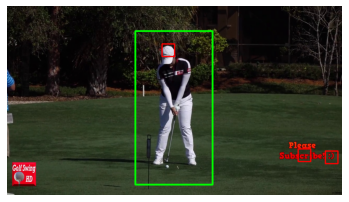

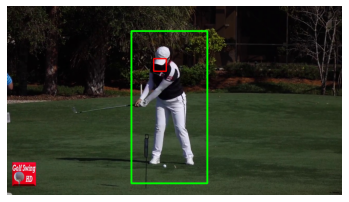

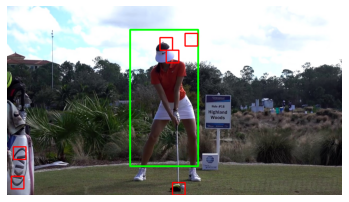

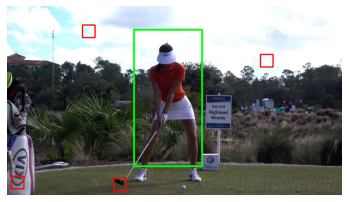

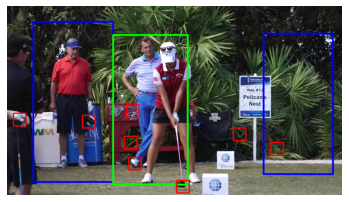

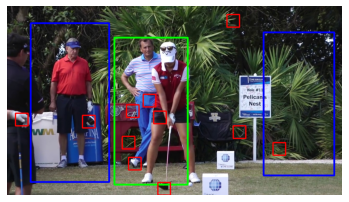

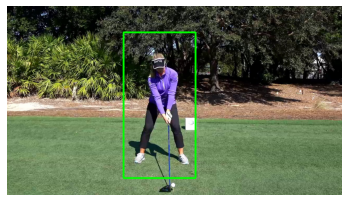

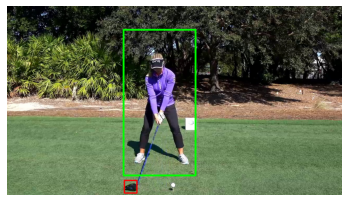

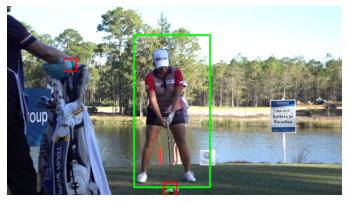

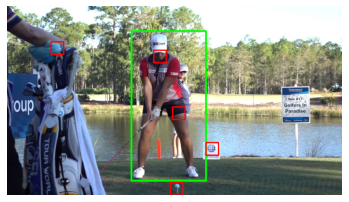

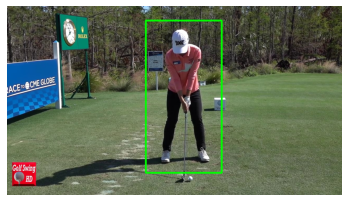

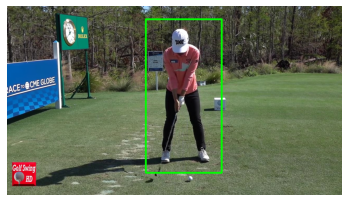

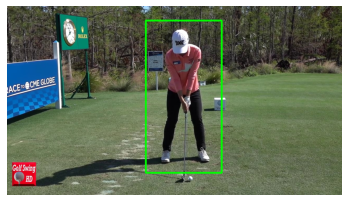

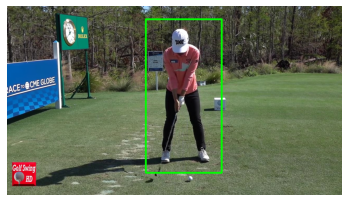

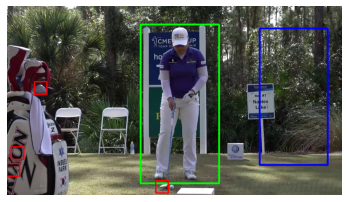

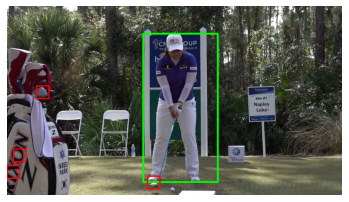

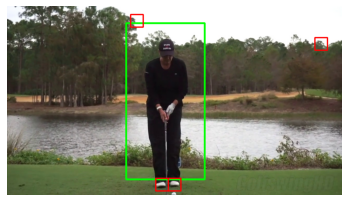

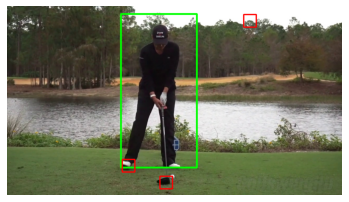

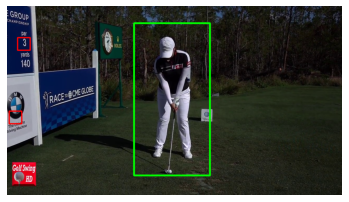

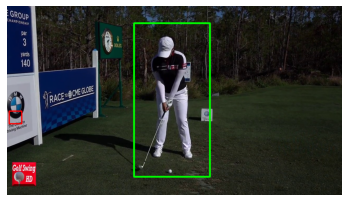

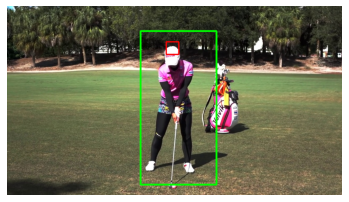

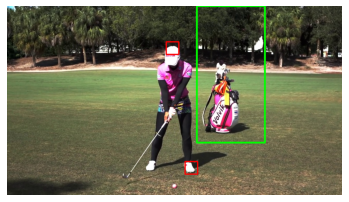

In [6]:
for folder in folders:
    for img_path in list(folder.rglob('*.jpg'))[:2]:
        image = cv2.imread(img_path.as_posix())
        plot_image = image.copy()

        human_locs,human_loc = human_detector.detect(image)
        for x,y,w,h in human_locs:
            cv2.rectangle(plot_image,(x,y),(x+w,y+h),(255,0,0),5)
        x,y,w,h = human_loc
        cv2.rectangle(plot_image,(x,y),(x+w,y+h),(0,255,0),5)
        
        club_locs = club_detector.detect(image)
        for x,y,w,h in club_locs:
            cv2.rectangle(plot_image,(x,y),(x+w,y+h),(0,0,255),3)
            
        plt.imshow(cv2.cvtColor(plot_image,cv2.COLOR_BGR2RGB))
        plt.axis(False)
        plt.show()